In [14]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit, fmin
import gatspy
%matplotlib inline

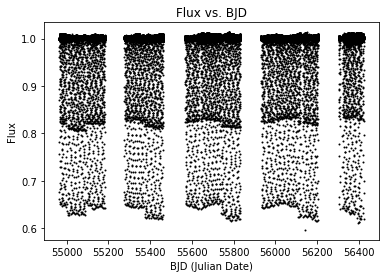

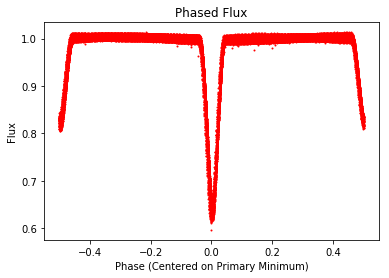

In [2]:
#loading the data
data = np.loadtxt('09540450.00.lc.data', unpack = 'True')
time = data[0, :]
flux = data[6, :]
sigma = data[7, :]

period = 2.1547127
t0 = time[list(flux).index(min(flux))] + (period*0.5)#centering phase graph on the minimum

#calculating phase (decimal portion of time elapsed/period)
phase = []
for t in time:
    p = abs((t-t0)/period - int((t-t0)/period))
    phase.append(p)

phase_arr = np.array(phase)
phase_arr = phase_arr - 0.5

#times series graph
plt.plot(time, flux, 'ko', markersize = 1)
plt.title('Flux vs. BJD')
plt.xlabel('BJD (Julian Date)')
plt.ylabel('Flux')
plt.savefig('KIC_9540450time.png')

#phased graph
plt.figure()
plt.plot(phase_arr, flux, 'ro', markersize = 1)
plt.title('Phased Flux')
plt.xlabel('Phase (Centered on Primary Minimum)')
plt.ylabel('Flux')

plt.savefig('KIC_9540450phase.png')

In [3]:
#defining the models for creating a fitted light-curve 
def make_fourier(N, m0):
    def fourier(x,*a):
        f = m0
        for i in range(0, N):
            f += a[i]*np.cos((i+1)*2*np.pi*x)
        for i in range(N, N + N):
            f += a[i]*np.sin((i+1)*2*np.pi*x)
        return f
    return fourier

def make_fourier_neg(N, m0):
    def fourier(x,*a):
        f = m0
        for i in range(0, N):
            f += a[i]*np.cos((i+1)*2*np.pi*x)
        for i in range(N, N + N):
            f += a[i]*np.sin((i+1)*2*np.pi*x)
        return -f
    return fourier
    

Finding optimal frequency:
 - Estimated peak width = 0.0563
 - Using 5 steps per peak; omega_step = 0.0113
 - User-specified period range:  0.01 to 1
 - Computing periods at 55249 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


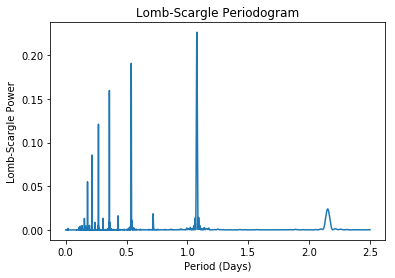

Period is: 0.04010737274736274


In [16]:
data = np.loadtxt('09540450.00.lc.data', unpack = 'True')
t = data[0,0:5000]
phase = data[1,0:5000]
mag = data[6,0:5000] #flux
dmag = data[7,0:5000]
periods = np.linspace(0.0000000001,2.5,10000)
model = gatspy.periodic.LombScargle().fit(t,mag,dmag)
power = model.score(periods)
fig,ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlabel ='Period (Days)',ylabel='Lomb-Scargle Power', title='Lomb-Scargle Periodogram')
model.optimizer.period_range=(.01,1) #accuracy depends on scale of range
period = model.best_period
period_true = period*2
plt.savefig('lombscargleplot.png')
plt.show()

print('Period is:',period_true)

In [4]:
def classify(data, period, name, N):
    '''Fits an analytical light curve, and classifies binary system based on given photometric data.
    Inputs: data (name of file), string
            period, float
            name of star/label for the graphs, string
            N - number of cosines for fourier fit
    Outputs: flux graph and fitted curve
             final fit coefficients, covariance matrix
             classification of the system'''
    data = np.loadtxt(data, unpack = 'True')
    time = data[0, :]
    flux = data[6, :]
    sigma = data[7, :]

    t0 = time[list(flux).index(min(flux))] + (period*0.5) #centering phase graph on the primary minimum

    #calculating phase (decimal portion of time elapsed/period)
    phase = []
    for t in time:
        p = abs((t-t0)/period - int((t-t0)/period))
        phase.append(p)

    phase_arr = np.array(phase)
    phase_arr = phase_arr - 0.5

    #time vs flux graph
    plt.figure()
    plt.plot(time, flux, 'ko', markersize = 1)
    plt.title('Flux vs. BJD')
    plt.xlabel('BJD (Julian Date)')
    plt.ylabel('Flux')
    plt.savefig('{}bjdplot.png'.format(name))

    #phased graph
    plt.figure()
    plt.plot(phase_arr, flux, 'ro', markersize = 1)
    plt.title('Phased Flux')
    plt.xlabel('Phase')
    plt.ylabel('Flux')

    m = sp.mean(flux)
    par0 = [0.02]*2*N
    par, cov = curve_fit(make_fourier(N, m), phase_arr, flux, par0)

    a2 = par[1]
    a4 = par[3]

    #classifying the system 
    classification = ''
    if abs(a4) <= abs(a2*(0.125+a2)):
        classification = 'contact'
    if abs(a4) > abs(a2*(0.125+a2)):  
        classification = 'semi-detached or noncontact binary'

    x = np.linspace(-0.5, 0.5, 1000)
    y = (make_fourier(N, m))(x, *par)
    plt.plot(x, y, 'k')
    plt.legend(['Observed Data', 'Model Light-Curve'])
    plt.savefig('{}fluxfitplot.png'.format(name))
    
    chi_squared = np.sum(((((make_fourier(N, m))(phase_arr, *par)) - flux)/sigma)**2)
    reduced_chi_squared = (chi_squared)/(len(phase_arr)-len(par))
    
    return par, cov, classification, reduced_chi_squared


In [5]:
def data_spread(phases, fluxes, N):
    '''Given a dataset, gives average spread of data around fitted curve.
    Inputs: phases, fluxes (arrays)
    Outputs: average spread around model (fourier fitted curve), float'''
    m0 = sp.mean(fluxes)
    size = int(len(phases)/N)
    markers = []
    n = 0
    while (size*n) <= len(phases):
        markers.append(size*n)
        n+=1
    if markers[-1] != len(phases):
        markers.append(len(phases))

    sort_index = np.argsort(phases)
    phases = phases[sort_index]
    fluxes = fluxes[sort_index]

    spreads = []
    for i in range(len(markers)-1):
        r = range(markers[i], markers[i+1])
        model = (make_fourier(15, m0))(phases[r], *par)
        interval = fluxes[r]
        diff = interval - model
        spread = max(diff) - min(diff)
        spreads.append(spread)
    spread_avg = sp.mean(spreads)
    return spread_avg
    

In [6]:
def plot_simulated(spread, sigmas):
    '''Fit, plot, chi-squared for simulated data to determine goodness of fit. 
    Inputs: m0 = average flux of simulated data set
            spread (computed from spread_avg function), float
            sigmas (array of error)
    Outputs: plot w/ new fit, simulated data, chi-squared'''
    
    x = np.linspace(-0.5, 0.5, len(sigmas))
    simulated_data = (make_fourier(15, m0))(x, *par) + spread*np.random.uniform(-0.5, 0.5, len(x)) + sigmas[0]*np.random.randn(len(x))

    plt.plot(x, simulated_data, 'ro', markersize=1)

    N = 15
    m = sp.mean(simulated_data)
    par0 = [0.02]*2*N
    par, cov = curve_fit(make_fourier(N, m), x, simulated_data, par0)

    x1 = np.linspace(-0.5, 0.5, 500)
    y1 = (make_fourier(N, m))(x1, *par)
    plt.plot(x1, y1, 'k')

    chi_squared = np.sum((((make_fourier(N, m))(x, *par) - simulated_data)/sigmas)**2)
    reduced_chi_squared = (chi_squared)/(len(x)-len(par))

    print(reduced_chi_squared)

3198.774711693814


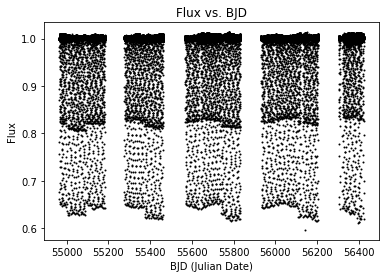

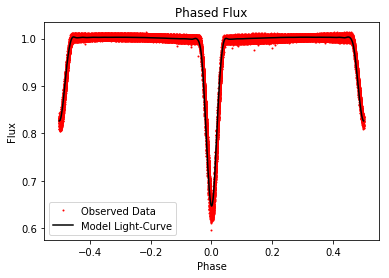

In [7]:
par, cov, classification, chi = classify('09540450.00.lc.data', period_true, 'KIC_9540450', 30)
print(chi)

3031.705185282295


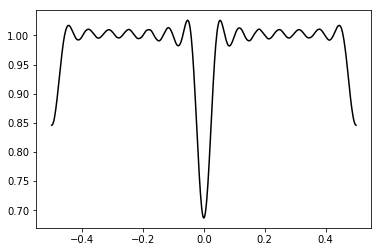

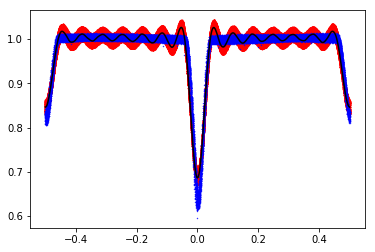

In [19]:
spread_avg = data_spread(phase_arr, flux, 100)
m0 = sp.mean(flux)
x2 = np.linspace(-0.5, 0.5, 500)
y2 = (make_fourier(30, m0))(x2, *par)
plt.plot(x2, y2, 'k')

x = np.linspace(-0.5, 0.5, len(phase_arr))
simulated_data = (make_fourier(15, m0))(x, *par) + spread_avg*np.random.uniform(-0.5, 0.5, len(x)) + sigma[0]*np.random.randn(len(x))

plt.figure()
plt.plot(x, simulated_data, 'ro', markersize=1)

N = 30
m = sp.mean(simulated_data)
par0 = [0.02]*2*N
par, cov = curve_fit(make_fourier(N, m), x, simulated_data, par0)

x1 = np.linspace(-0.5, 0.5, 500)
y1 = (make_fourier(N, m))(x1, *par)
plt.plot(phase_arr, flux, 'bo', markersize = 0.4)
plt.plot(x1, y1, 'k')


chi_squared = np.sum((((make_fourier(N, m))(x, *par) - simulated_data)/sigma)**2)
reduced_chi_squared = (chi_squared)/(len(x)-len(par))

print(reduced_chi_squared)


In [21]:
def temp_ratio(par, m, x):
    '''Set of parameters for fitted function and average flux, guesses for mins, max, output temperature ratio'''
    fourier = make_fourier(15, m)
    fourier_neg = make_fourier_neg(15, m)

    args = []
    for p in par:
        args.append(p)
    args = tuple(args)

    #minima
    min0 = fmin(fourier, x[0], args, disp=False)
    min_val_0 = fourier(min0, *args)

    min1 = fmin(fourier, x[1], args, disp=False)
    min_val_1 = fourier(min1, *args)

    #maximum
    max1 = fmin(fourier_neg, x[2], args, disp=False)
    max_val = fourier_neg(max1, *args)
    max_val *= -1

    T_ratio = ((max_val - min_val_0)/(max_val - min_val_1))**0.25
    return(T_ratio)

In [4]:
def radii_ratio(par, m, x):
    fourier = make_fourier(15, m)
    fourier_neg = make_fourier_neg(15, m)

    args = []
    for p in par:
        args.append(p)
    args = tuple(args)

    #finding the minima of our computed light curves
    #primary min
    min0 = fmin(fourier, x[0], args, disp=False)
    min_val_0 = fourier(min0, *args)

    #secondary min
    min1 = fmin(fourier, x[1], args, disp=False)
    min_val_1 = fourier(min1, *args)

    #finding the maximum of our computed light curves
    max1 = fmin(fourier_neg, x[2], args, disp=False)
    max_val = fourier_neg(max1, *args)
    max_val *= -1

    R_ratio = ((max_val - min_val_1)/(min_val_0))**0.5
    return R_ratio

semi-detached or noncontact binary


NameError: name 'temp_ratio' is not defined

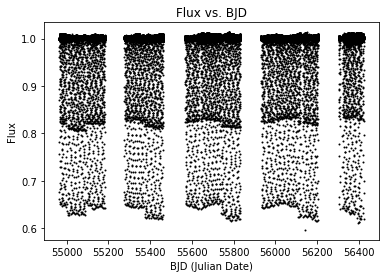

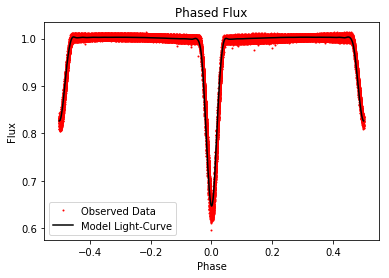

In [8]:
data = np.loadtxt('09540450.00.lc.data', unpack=True)
flux4 = data[6,:]
m = sp.mean(flux4)

par5, cov5, classification5, chi5 = classify('09540450.00.lc.data', 2.1547127, 'KIC_9540450', 30)
print(classification5)

t_ratio = temp_ratio(par5, m, [-0.2, -0.45, -0.35])
print('Temperature ratio between the two components is: ', t_ratio[0])

r_ratio = radii_ratio(par5, m, [-0.2, -0.45, -0.35])
print('Radius ratio between the two components is: ', r_ratio[0])